In [16]:
# imports.py
from imports import *
# custom mods
import tidy

import nltk
import pandas as pd
import numpy as np
from env import *

import tweepy as tw 
import scipy.stats as stats

from datetime import datetime

import nltk.sentiment
import wrangle

from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, r2_score, mean_squared_error


In [5]:
df=tidy.explore_df()

cached csv


# Target exploration

In [4]:
df.index.min()

Timestamp('2014-09-17 00:00:00+0000', tz='UTC')

In [5]:
df.index.max()

Timestamp('2022-05-24 00:00:00+0000', tz='UTC')

<AxesSubplot:>

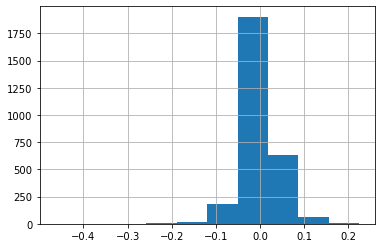

In [6]:
df.fwd_log_ret.hist()

<AxesSubplot:>

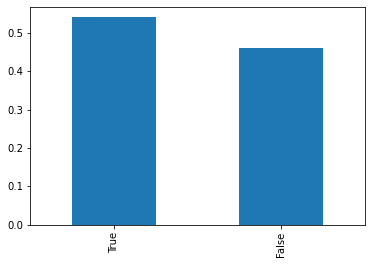

In [7]:
df.fwd_close_positive.value_counts(normalize=True).plot.bar()

# Volatility exploration

### When volatility is high what kind of returns are expected? 
- Measure this using ATR:
    - TR = Max[(H-L), Abs(H-Cp), Abs(L-Cp)]
    - ATR = (1/n)* sum(TRi)

In [8]:
from talib import ATR

In [9]:
def add_ATR_feature(df):
    """Adds columns with boolean of whether current and historical ATR 
    is greater than the ATR threshold (percentage)"""
    
    df_calc = df.copy()

    # Calculate the 14 day ATR and add it as column to df
    df_calc['ATR_14'] = ATR(df_calc.high, df_calc.low, df_calc.close, 14)
    # Calculate the rolling 14 day average of ATR and add it as column to df
    df_calc['avg_atr_14'] = df_calc.ATR_14.rolling(14).mean()
    # Calculate the percentage current 14 day ATR is above/below the rolling mean
    df_calc['atr_vs_historical'] = (df_calc.ATR_14 - df_calc.avg_atr_14)/df_calc.avg_atr_14
    
    thresholds_to_add = [0.01, 0.05, 0.1, 0.2, 0.3]
    
    for threshold in thresholds_to_add:
        df[f'atr_above_threshold_{threshold}'] = df_calc.atr_vs_historical>threshold
    
    return df

In [10]:
add_ATR_feature(df)

,open,high,low,close,volume,fwd_log_ret,fwd_ret,fwd_pct_chg,fwd_close_positive,atr_above_threshold_0.01,atr_above_threshold_0.05,atr_above_threshold_0.1,atr_above_threshold_0.2,atr_above_threshold_0.3
date,,,,,,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,-0.074643,-32.894013,-0.071926,False,False,False,False,False,False
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,-0.072402,-29.644012,-0.069843,False,False,False,False,False,False
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.035111,14.108002,0.035735,True,False,False,False,False,False
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,-0.024968,-10.082978,-0.024659,False,False,False,False,False,False
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.008317,3.330994,0.008352,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20 00:00:00+00:00,30311.119141,30664.976563,28793.605469,29200.740234,30749382605,0.007896,231.486329,0.007927,True,True,False,False,False,False
2022-05-21 00:00:00+00:00,29199.859375,29588.869141,29027.394531,29432.226563,17274840442,0.029840,891.496093,0.030290,True,False,False,False,False,False
2022-05-22 00:00:00+00:00,29432.472656,30425.861328,29275.183594,30323.722656,21631532270,-0.041230,-1224.812500,-0.040391,False,False,False,False,False,False


In [11]:
def perform_ATR_analysis(df, atr_threshold  = 0.05, make_plots = True, alpha = 0.05):
    """Performs analysis of returns based on current vs historical ATR.
    
    If the difference in current and historical ATR is greater than the ATR threshold (percentage)"""

    # Calculate the 14 day ATR and add it as column to df
    df['ATR_14'] = ATR(df.high, df.low, df.close, 14)
    # Calculate the rolling 14 day average of ATR and add it as column to df
    df['avg_atr_14'] = df.ATR_14.rolling(14).mean()
    # Calculate the percentage current 14 day ATR is above/below the rolling mean
    df['atr_vs_historical'] = (df.ATR_14 - df.avg_atr_14)/df.avg_atr_14

    if make_plots:
    # Plot ATR 14 and close price
        fig, ax = plt.subplots(2,1,sharex=True)
        df.close.plot(ax = ax[0])
        ax[0].set_title('Close price of BTC')
        df.avg_atr_14.plot(ax = ax[1])
        ax[1].set_title('Rolling 14 day average of 14 day ATR')

    df['atr_above_threshold'] = df.atr_vs_historical>atr_threshold

    print(f"Percentage of observations above threshold: {df.atr_above_threshold.mean():.2%}")
    
    avg_return_above_threshold = round(df[df.atr_above_threshold].fwd_log_ret.mean(),6)
    
    print(f"Average next day return when ATR above threshold: {avg_return_above_threshold}")
    
    print(f"which is: {round(df[df.atr_above_threshold].fwd_log_ret.mean()/df.fwd_log_ret.mean(),3)} times overall average")
    
    # Perform one sample t-test -> is the average return of the high volatility days significantly greater than overall mean?
    
    t,p = stats.ttest_1samp(df[df.atr_above_threshold].fwd_log_ret, df.fwd_log_ret.mean())
    
    if ((t>0)&(p/2<alpha)):
        print("Results significant!: t is >0",t>0,"p/2 < alpha",p<alpha)
    else:
        print("Fail to reject null hypothesis")
        
    return avg_return_above_threshold
    

In [12]:
thresholds_to_try = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
returns = {}
for threshold in thresholds_to_try:
    avg_return = perform_ATR_analysis(df, atr_threshold=threshold, make_plots=False)
    returns[threshold] = avg_return


Percentage of observations above threshold: 38.69%
Average next day return when ATR above threshold: 0.002414
which is: 1.624 times overall average
Fail to reject null hypothesis
Percentage of observations above threshold: 30.00%
Average next day return when ATR above threshold: 0.004002
which is: 2.692 times overall average
Fail to reject null hypothesis
Percentage of observations above threshold: 22.19%
Average next day return when ATR above threshold: 0.00423
which is: 2.845 times overall average
Fail to reject null hypothesis
Percentage of observations above threshold: 12.36%
Average next day return when ATR above threshold: 0.00517
which is: 3.477 times overall average
Fail to reject null hypothesis
Percentage of observations above threshold: 7.59%
Average next day return when ATR above threshold: 0.00443
which is: 2.98 times overall average
Fail to reject null hypothesis
Percentage of observations above threshold: 4.99%
Average next day return when ATR above threshold: -0.002062


Text(5, 0.0017, 'Overall Mean')

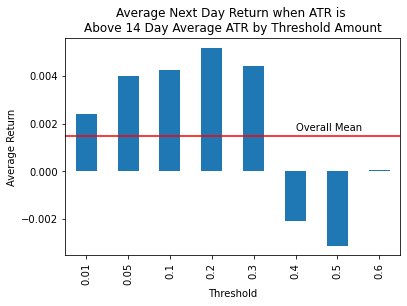

In [13]:
pd.DataFrame(returns, index = ['avg_return']).T.plot.bar(legend=False)
plt.title('Average Next Day Return when ATR is \nAbove 14 Day Average ATR by Threshold Amount')
plt.xlabel('Threshold')
plt.ylabel('Average Return')
plt.axhline(df.fwd_log_ret.mean(), color = 'r')
plt.annotate('Overall Mean', (5, 0.0017))


<AxesSubplot:xlabel='date'>

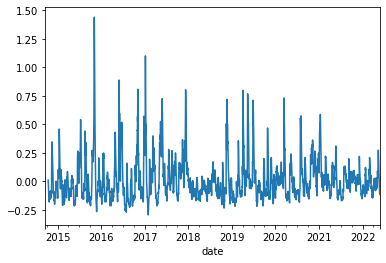

In [14]:
df.atr_vs_historical.plot()

When current ATR gets very extended from mean, what are next day returns?
- very extended defined as difference in current ATR from 14 day historical ATR as greater than the 3rd quartile

In [15]:
atr_threshold = df.atr_vs_historical.quantile(0.75)

df['atr_above_threshold'] = df.atr_vs_historical>atr_threshold

df.atr_above_threshold.mean()

0.24759529747060918

As expected, the difference in current volatility from 14 day average is above threshold 25% of the time

What is the average return when (Current ATR - Historical ATR) > threshold? How does this compare with overall average?

In [16]:
df[df.atr_above_threshold].fwd_log_ret.mean()

0.004058148250319954

How does this compare to overall average?

In [17]:
df[df.atr_above_threshold].fwd_log_ret.mean()/df.fwd_log_ret.mean()

2.7296384679490866

Nearly 3 times as high as average. Check for statistical significance at the 95% confidence level:
- H0: Days with volatility above the threshold do not exhibit above average returns
- H1: Days with volatility above the threshold return in above average next day returns

In [18]:
alpha = 0.05
t,p = stats.ttest_1samp(df[df.atr_above_threshold].fwd_log_ret, df.fwd_log_ret.mean())

print("t is >0",t>0,"p/2 < alpha",p<alpha)

t is >0 True p/2 < alpha False


Cannot reject the null hypothesis - days with above average volatility do not result in above average next day returns. Will try additional thresholds

# Bollinger Band exploration

### Bollinger bands - when price is "stretched" a certain point from its average do we expect returns to be greater?

In [19]:
from talib import BBANDS

In [20]:
# Create 5 period sma as middle band, 2 std dev +- for upper and lower bands
df['upperband2'], df['middleband'], df['lowerband2'] = BBANDS(df.close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)

df['upperband1'], df['middleband'], df['lowerband1'] = BBANDS(df.close, timeperiod=5, nbdevup=1, nbdevdn=1, matype=0)



# create columns true when low below lower band, another column true when high above upper band
df['low_below_lower1'] = df.low < df.lowerband1
df['high_above_upper1'] = df.high > df.upperband1

df['low_below_lower2'] = df.low < df.lowerband2
df['high_above_upper2'] = df.high > df.upperband2

In [21]:
df.low_below_lower1.mean()

0.46597791236195224

In [22]:
df.high_above_upper1.mean()

0.5553972212326327

What is the average forward return when low below lower and what is it when high above upper?

In [23]:
df[df.low_below_lower2].fwd_log_ret.mean()

5.468772458423057e-05

In [24]:
df[df.high_above_upper2].fwd_log_ret.mean()

0.00025614540533167523

In [25]:
df[df.low_below_lower1].fwd_log_ret.mean()

-0.0002509609606985909

In [26]:
df[df.high_above_upper1].fwd_log_ret.mean()

0.002590890403563458

In [27]:
df.fwd_log_ret.mean()

0.0014866980730122267

Overall the returns are much less than average when price is stretched 2 std dev away from the mean

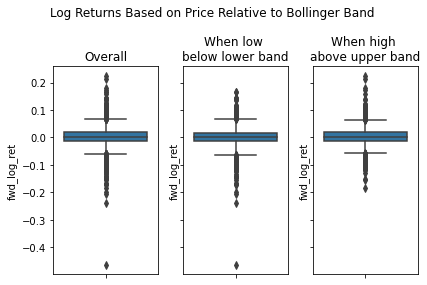

In [28]:
fig, ax = plt.subplots(1,3,sharey=True)
sns.boxplot(y=df.fwd_log_ret, ax = ax[0])
ax[0].set_title('Overall')
sns.boxplot(y=df[df.low_below_lower1].fwd_log_ret, ax=ax[1])
ax[1].set_title('When low \nbelow lower band')
sns.boxplot(y=df[df.high_above_upper1].fwd_log_ret, ax = ax[2])
ax[2].set_title('When high \nabove upper band')
plt.suptitle('Log Returns Based on Price Relative to Bollinger Band')
plt.tight_layout()

In [29]:
# plt.figure(figsize = (18,8))
# sample = df.loc['08-2020']
# sample.high.plot()
# sample.upperband.plot()
# sample.lowerband.plot()
# plt.legend()

Perform t-test

In [30]:
to_test = ['low_below_lower2', 'low_below_lower1', 'high_above_upper1', 'high_above_upper2']
overall_mean = df.fwd_log_ret.mean()
alpha = 0.05
for test in to_test:
    sample = df[df[test]].fwd_log_ret
    t,p = stats.ttest_1samp(sample, overall_mean)
    print(test, t, p/2<alpha)

low_below_lower2 -0.7212809213135888 False
low_below_lower1 -1.5194888178095236 False
high_above_upper1 1.201382924201341 False
high_above_upper2 -0.6961508741026569 False


Nothing significant

# Explore other features

### Explore consolidation then breakout of price

# Modeling

In [6]:
df = wrangle.wrangle_df()

cached csv


In [7]:
df.head(5)

,open,high,low,close,volume,fwd_log_ret,fwd_ret,fwd_pct_chg,fwd_close_positive,cross,...,atr_above_threshold_0.1,atr_above_threshold_0.2,atr_above_threshold_0.3,avg-fees-per-transaction,cost-per-transaction-percent,cost-per-transaction,difficulty,hash-rate,miners-revenue,transaction-fees-to-miners
2014-10-20,389.230988,390.084015,378.252014,382.845001,16419000,0.009437,3.630005,0.009482,1,0.0,...,False,False,False,0.059651,2.830044,24.826121,3.500248e+10,233157.697776,1.747486e+06,4198.799233
2014-10-21,382.420990,392.645996,380.834015,386.475006,14188900,-0.008620,-3.317016,-0.008583,0,0.0,...,False,False,False,0.060749,2.830044,20.194035,3.500248e+10,233157.697776,1.903490e+06,5726.216590
2014-10-22,386.118011,388.575989,382.248993,383.157990,11641300,-0.066750,-24.740998,-0.064571,0,0.0,...,False,False,False,0.060749,2.830044,20.194035,3.500248e+10,297537.062088,1.903490e+06,5726.216590
2014-10-23,382.962006,385.048004,356.446991,358.416992,26456900,-0.000201,-0.071991,-0.000201,0,0.0,...,False,False,False,0.060749,2.566983,20.194035,3.500248e+10,297537.062088,1.903490e+06,5726.216590
2014-10-24,358.591003,364.345001,353.304993,358.345001,15585700,-0.031391,-11.074005,-0.030903,0,0.0,...,False,False,False,0.056403,2.566983,18.762679,3.500248e+10,297537.062088,1.603290e+06,4819.681933


In [8]:
features_to_use = ['close','atr_above_threshold_0.01',
       'atr_above_threshold_0.05', 'atr_above_threshold_0.1',
       'atr_above_threshold_0.2', 'atr_above_threshold_0.3']

features_to_scale = ['close','atr_above_threshold_0.01']

# Define length of each test set
test_size = 30

# Define models to test
models_to_test = [DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)]

# Define the target
target = 'fwd_close_positive'

In [9]:
def rolling_split_train_and_test(df, features_to_use, features_to_scale, target, num_splits = 5, test_size = 30):
    """ Splits dataset into train and test sets. Returns list of X_trains, X_tests, y_trains, y_tests
    
    Arguments:
    df: the full dataset included features and target(s)
    features_to_use: list of features to be used in the model
    features_to_scale: list of features to scale
    target: the desired target
    num_splits: number of datasets to create
    test_size: number of datapoints to use for test sets
    """
    
    
    # Create the initial X and y matrices
    # X consists of only selected features
    # Withholding the final <<test_size>> to save for a final test on unseen data
    X = df[features_to_scale].iloc[:-test_size]
    y = df[[target]].iloc[:-test_size]
    
    # Instantiate Time Series Split
    tscv = TimeSeriesSplit(n_splits = num_splits, test_size = test_size)

    # Initialize the muliplier variable, which is used to shift the start date of train set forward
    multiplier = 0

    train_X_sets = []
    test_X_sets = []
    train_y_sets = []
    test_y_sets = []

    # Iterate through the splits created by tscv and create list of X and y train and test sets
    for train_index, test_index in tscv.split(X):
        # Sets up the rolling part of the split by moving the start index of forward by test_size for each split s
        # First split starts at 0, second starts at index = test_size, s split starts at 0+(s-1)*(test_size)
        train_index = train_index[multiplier * test_size:]

        # print("Train:", df.index[train_index], "Test:", df.index[test_index])
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Perform scaling after the split so scaler can be fit to each train set individually
        X_train_scaled, X_test_scaled = scale_X(X_train, X_test, features_to_use, features_to_scale, scaler_type = StandardScaler())

        # Increments multiplier for next split
        multiplier += 1

        train_X_sets.append(X_train_scaled)
        test_X_sets.append(X_test_scaled)
        train_y_sets.append(y_train)
        test_y_sets.append(y_test)

    return train_X_sets, test_X_sets, train_y_sets, test_y_sets

In [10]:
def scale_X(X_train, X_test, features_to_use, features_to_scale, scaler_type):
    """ Scales X_train, X_test using scaler_type. Only scales features_to_scale """
    scaler = scaler_type
    
    X_train_scaled = pd.concat([X_train.drop(columns = features_to_scale),
                                pd.DataFrame(data = scaler.fit_transform(X_train[features_to_scale]), 
                                             columns = features_to_scale, index = X_train.index)], 
                               axis=1)
    X_test_scaled = pd.concat([X_test.drop(columns = features_to_scale),
                                pd.DataFrame(data = scaler.transform(X_test[features_to_scale]), 
                                             columns = features_to_scale, index = X_test.index)], 
                               axis=1)
    
    return X_train_scaled, X_test_scaled

In [31]:
def train_classifier(X_train, y_train, target = 'fwd_close_positive', class_model = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=2)):
    """ Trains classifer for inputted model. 
    Arguments:
    X_train: features
    y_train: target
    target: column name for target
    class_model: the model to use
    
    Outputs dictionary of classification report, the classifier object, and numpy array of predictions """
    
    # Extracts name of the algorithm
    algorithm_name = class_model.__repr__().split('()')[0].split('(')[0]
    
    # Extracts the hyperparameters
    model_hyperparameters = class_model.get_params()
    
    # Fits classifier to train set
    clf = class_model.fit(X_train, y_train[target])
    
    # Predict on train
    train_predictions = class_model.predict(X_train)
    
    # Generate classification report for train
    train_classification_report = classification_report(y_train[target], train_predictions, output_dict=True)
    
    # Add additional data for function output
    train_classification_report['algorithm'] = algorithm_name
    
    train_classification_report['hyperparameters'] = model_hyperparameters
    
    train_classification_report['features_used'] = X_train.columns
    
    return train_classification_report, clf, train_predictions

def test_classifier(X_test, y_test, clf, target='fwd_close_positive'):
    """ Tests the classifier on test set """
    
    # Extracts name of the algorithm
    algorithm_name = clf.__repr__().split('()')[0].split('(')[0]
    
    # Extracts the hyperparameters for model
    model_hyperparameters = clf.get_params()
    
    # Predict on test
    test_predictions = clf.predict(X_test)
    
    # Generate classification report for test
    test_classification_report = classification_report(y_test[target], test_predictions, output_dict=True)
    
    # Add additional data for function output
    test_classification_report['algorithm'] = algorithm_name
    
    test_classification_report['hyperparameters'] = model_hyperparameters
    
    test_classification_report['features_used'] = X_test.columns
    
    return test_classification_report, test_predictions
def compute_class_baseline_accuracy(y, target):
    """ Determine baseline from train and calculate accuracy on train """
    
    # use the mode of y (most common category) as baseline
    baseline_selection = y[target].mode()[0]
    
    # return accuracy
    return baseline_selection, (y[target] == baseline_selection).mean()

def compute_baseline_accuracy_on_test(y, baseline_selection, target):
    """ Use baseline selection from train to calculate performance on test/validate """
    
    return (y[target] == baseline_selection).mean()

def test_baseline(y_train, y_test, set_number):
    """ Calculates baseline performance for classification by using the mode of the value in train """
    # Calculate baseline performance
    baseline_selection, baseline_train_accuracy = compute_class_baseline_accuracy(y_train, target)
    test_accuracy = compute_baseline_accuracy_on_test(y_test, baseline_selection, target)
    
    print("Split: ", set_number)
    print(f"Train: {y_train.index.min().date()} - {y_train.index.max().date()}")
    print(f"Test: {y_test.index.min().date()} - {y_test.index.max().date()}")
    print("Baseline selection from train: ", baseline_selection)
    print("Baseline train accuracy: ", round(baseline_train_accuracy,2))
    print("Baseline performance on validate: ", round(test_accuracy,2))
    
    return baseline_selection, baseline_train_accuracy, test_accuracy

def train_and_test_dataset(model_under_test, X_train, X_test, y_train, y_test, target):
    """Test one model by fitting on train and testing on test set"""
    
    # Train classifier
    train_classification_report, clf, train_predictions = train_classifier(X_train, y_train, target = target, class_model = model_under_test)
    
    print("Train accuracy: ", train_classification_report['accuracy'])
    
    # Test classifier on test set
    test_classification_report, test_predictions = test_classifier(X_test, y_test, clf, target = target)
    
    print("Test accuracy: ", test_classification_report['accuracy'])

In [32]:
train_X_sets, test_X_sets, train_y_sets, test_y_sets = rolling_split_train_and_test(df, features_to_use, features_to_scale, target, num_splits = 5, test_size= 30)

# iterate through each train/test split in the data
for dataset_number in range(len(train_X_sets)):
    # Test baseline
    test_baseline(train_y_sets[dataset_number], 
                  test_y_sets[dataset_number], 
                  set_number = dataset_number+1)
    
    # Train and test using model
    train_and_test_dataset(models_to_test[0],
                           train_X_sets[dataset_number], 
                           test_X_sets[dataset_number], 
                           train_y_sets[dataset_number], 
                           test_y_sets[dataset_number], 
                           target)

Split:  1
Train: 2014-10-20 - 2021-11-25
Test: 2021-11-26 - 2021-12-25
Baseline selection from train:  1
Baseline train accuracy:  0.54
Baseline performance on validate:  0.53
Train accuracy:  0.5543562066306862
Test accuracy:  0.5333333333333333
Split:  2
Train: 2014-11-19 - 2021-12-25
Test: 2021-12-26 - 2022-01-24
Baseline selection from train:  1
Baseline train accuracy:  0.54
Baseline performance on validate:  0.4
Train accuracy:  0.5543562066306862
Test accuracy:  0.4
Split:  3
Train: 2014-12-19 - 2022-01-24
Test: 2022-01-25 - 2022-02-23
Baseline selection from train:  1
Baseline train accuracy:  0.54
Baseline performance on validate:  0.53
Train accuracy:  0.5535851966075559
Test accuracy:  0.5333333333333333
Split:  4
Train: 2015-01-18 - 2022-02-23
Test: 2022-02-24 - 2022-03-25
Baseline selection from train:  1
Baseline train accuracy:  0.54
Baseline performance on validate:  0.53
Train accuracy:  0.5543562066306862
Test accuracy:  0.5333333333333333
Split:  5
Train: 2015-02-17 

In [30]:
# baseline - what is the most common class?
y_train.fwd_close_positive.value_counts()

1    1415
0    1179
Name: fwd_close_positive, dtype: int64

Most common class is a positive forward close, therefore this will be used as baseline. Essentially this means everyday we predict a positive close. How often would we be correct?

In [43]:
# Get the mode from train
baseline_selection = y_train.fwd_close_positive.mode()[0]

# Create column with baseline predictions
y_train['baseline_performance'] = y_train.fwd_close_positive == baseline_selection

# Take the mean to get accuracy
y_train.baseline_performance.mean()

/var/folders/tt/99v8dp0d60sfw82fs51dhr4m0000gn/T/ipykernel_13755/2877207783.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['baseline_performance'] = y_train.fwd_close_positive == baseline_selection


0.5454895913646878

54.5% is our baseline accuracy from train

In [60]:
class_model = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=2)

class_model.fit(X_train, y_train)

y_train['dtc']=class_model.predict(X_train)

accuracy_score(y_train.fwd_close_positive, y_train.dtc)

classification_report(y_train.fwd_close_positive, y_train.dtc, output_dict=True)

/var/folders/tt/99v8dp0d60sfw82fs51dhr4m0000gn/T/ipykernel_13755/2524274409.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['dtc']=class_model.predict(X_train)


{'0': {'precision': 0.7590361445783133,
  'recall': 0.05343511450381679,
  'f1-score': 0.09984152139461172,
  'support': 1179},
 '1': {'precision': 0.5555555555555556,
  'recall': 0.9858657243816255,
  'f1-score': 0.7106469689251146,
  'support': 1415},
 'accuracy': 0.5620663068619892,
 'macro avg': {'precision': 0.6572958500669344,
  'recall': 0.5196504194427212,
  'f1-score': 0.4052442451598631,
  'support': 2594},
 'weighted avg': {'precision': 0.6480396012216433,
  'recall': 0.5620663068619892,
  'f1-score': 0.4330295353713509,
  'support': 2594}}

How would baseline (predict positive close every day)

In [27]:
y_test['dtc'] = class_model.predict(X_test)
accuracy_score(y_test.fwd_close_positive, y_test.dtc)

/var/folders/tt/99v8dp0d60sfw82fs51dhr4m0000gn/T/ipykernel_13755/4173150054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['dtc'] = class_model.predict(X_test)


0.4666666666666667

# NLP Exploration

In [ ]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [ ]:
def get_later_tweets(tweet_csv = 'csv/latest_tweets.csv'):
    
    start_read_time = datetime.now()
    
    print("starting reading csv at: ", start_read_time)
    
    # https://www.kaggle.com/datasets/kaushiksuresh147/bitcoin-tweets
    latest_tweets = pd.read_csv(tweet_csv)
    
    print("done reading csv, took ", ((datetime.now() - start_read_time).seconds)/60, " minutes")
    
    # some values don't have proper date values
    latest_tweets= latest_tweets[latest_tweets.date.str.len()==19]

    # Set index to date
    latest_tweets.index = pd.to_datetime(latest_tweets.date)

    # create date column
    latest_tweets['date_of_tweet'] = latest_tweets.index.date

    # sort index and just use date and text going forward
    latest_tweets = latest_tweets.sort_index()[['date','text']]
    
    prices_df = tidy.explore_df()
    # Join with prices df to get Bitcoin price change for that date
    latest_tweets = latest_tweets.merge(prices_df, how='left',left_on=latest_tweets.index.date, right_on = prices_df.index.date)

    latest_tweets.index = pd.to_datetime(latest_tweets.key_0)

    latest_tweets = latest_tweets[['fwd_log_ret','text']]

    latest_tweets.index.name = ""
    
    return latest_tweets

In [ ]:
latest_tweets = get_later_tweets()

In [ ]:
latest_tweets.head()

In [ ]:
latest_tweets['sentiment'] = latest_tweets.text.apply(lambda msg: sia.polarity_scores(msg)['compound'])

In [ ]:
latest_tweets.resample('D').fwd_log_ret.agg('mean').plot()

In [ ]:
def read_and_clean_early_tweets(nrows = 1_000_000, time_column = 'timestamp', csv_location = 'csv/early_tweets.csv'):
    """ Reads in early tweets (until 2019), clean up the dates, and outputs dataframe with date and text of tweet """
    
    # Define required columns from the csv - this should speed up load
    req_cols = ['timestamp','likes','retweets','text']
    
    # Read CSV
    tweets = pd.read_csv(csv_location,nrows = nrows ,on_bad_lines='skip',sep=';', usecols = req_cols)
    
    print("Completed reading in csv, shape: ", tweets.shape)
    
    # Clean dates (sometimes the time column has non time values. If it's a timestamp should have set number of characters
    if time_column == 'time': # For reading in later tweets, that csv's time column is called 'time'
        tweets = tweets[tweets[time_column].str.len()==25]
    
    # convert time to datetime
    tweets[time_column]= pd.to_datetime(tweets[time_column])
    
    # Create date column
    tweets['date'] = tweets[time_column].dt.date
    
    # Only use date and text columns
    tweets = tweets[['date','text']]
    
    tweets.index = pd.to_datetime(tweets.date)
    
    return tweets

In [ ]:
# req_cols = ['timestamp','likes','retweets','text']
# tweets = pd.read_csv('csv/early_tweets.csv',nrows = 1000000,on_bad_lines='skip',sep=';', usecols = req_cols)
early_tweets = read_and_clean_early_tweets()

In [ ]:
early_tweets.shape

In [ ]:
early_tweets.head()

In [ ]:
early_tweets['sentiment'] = early_tweets.text.apply(lambda msg: sia.polarity_scores(msg)['compound'])

In [ ]:
tweets.resample('D').sentiment.mean().plot()

In [ ]:
def initial_tweet_clean(tweets,time_column = 'time'):
    # Clean dates
    if time_column == 'time':
        tweets = tweets[tweets[time_column].str.len()==25]

    tweets[time_column]= pd.to_datetime(tweets[time_column])

    tweets['date'] = tweets[time_column].dt.date

    tweets = tweets[['date','text']]
    
    return tweets


In [ ]:
cleaned_early_tweets = read_and_clean_early_tweets()

In [ ]:
# cleaned_tweets = initial_tweet_clean(tweets, 'timestamp')

In [ ]:
cleaned_tweets['sentiment'] = cleaned_tweets.text.apply(lambda msg: sia.polarity_scores(msg)['compound'])

In [ ]:
prepared_tweets = tidy.prepare_df(tweets.sample(5000), 'text')

prices = df

prepared_tweets = prepared_tweets.merge(prices, how = 'left', left_on = 'date', right_on = prices.index.date)

prepared_tweets.index = pd.to_datetime(prepared_tweets.date)

In [ ]:
lem_and_ret = prepared_tweets.resample('D').agg({'lemmatized':' '.join, 'fwd_log_ret':np.mean, 'fwd_close_positive':np.mean})

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
tweets['sentiment'] = tweets.text.apply(lambda msg: sia.polarity_scores(msg)['compound'])

In [ ]:
tweets.date.max()

## Short modeling test

In [ ]:
train = lem_and_ret.iloc[:20]

validate = lem_and_ret.iloc[20:]

In [ ]:
target = 'fwd_close_positive'

In [ ]:
# Instantiate the feature extraction method
feature_extraction_method = CountVectorizer(ngram_range=(1,1))

# Perform feature extraction on lemmatized text from train
X_train = feature_extraction_method.fit_transform(train.lemmatized)

# Generate dataframe of results of feature extraction
train_vectorizer_df = pd.DataFrame(X_train.todense(), columns=feature_extraction_method.get_feature_names_out())

# Set index to train index
train_vectorizer_df.index = train.index

# Add in other features (lengths of readme)
# X_train = pd.concat([train_vectorizer_df,train[['original_length','stem_length', 'lem_length', 'original_word_count',
#        'stemmed_word_count', 'lemmatized_word_count']]], axis = 1)

# Scale features in train (necessary for logistic regression)
# X_train_scaled = scaler.fit_transform(X_train)

# Perform feature extraction and add in additional features on validate
X_validate = feature_extraction_method.transform(validate.lemmatized)
validate_vectorizer_df = pd.DataFrame(X_validate.todense(), columns=feature_extraction_method.get_feature_names_out())
validate_vectorizer_df.index = validate.index

# X_validate = pd.concat([validate_vectorizer_df,validate[['original_length','stem_length', 'lem_length', 'original_word_count',
#        'stemmed_word_count', 'lemmatized_word_count']]], axis = 1)

# Scale validate
# X_validate_scaled = scaler.transform(X_validate)

# Define target 
y_train = train[target]
y_validate = validate[target]

In [ ]:
# Create dataframe of results from train and validate
train_results=pd.DataFrame(dict(actual = y_train))
validate_results = pd.DataFrame(dict(actual = y_validate))

class_model = LogisticRegression()
# Fit model to scaled train data 
model_to_use = class_model.fit(X_train, y_train)

# Predict on train and validate
train_results['predicted'] = model_to_use.predict(X_train)
validate_results['predicted'] = model_to_use.predict(X_validate)


In [ ]:
# Generate classification reports for train and validate
train_class_report = classification_report(train_results.actual, train_results.predicted, output_dict = True)
validate_class_report = classification_report(validate_results.actual, validate_results.predicted,output_dict=True)

In [ ]:

print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.predicted)))
print('---')
# print('Train Confusion Matrix')
# print(pd.crosstab(train_results_tfidf.predicted, train_results_tfidf.actual))
print('---')
print(pd.DataFrame(train_class_report))


print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.predicted)))
print('---')
# print('Validate Confusion Matrix')
# print(pd.crosstab(validate_results_tfidf.predicted, validate_results_tfidf.actual))
print('---')
print(pd.DataFrame(validate_class_report))